In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import os
import json
from sklearn.model_selection import train_test_split

# Пути к данным
coco_annotation_path = '/kaggle/input/wheels3k-coco/train/_annotations.coco.json'
images_dir = '/kaggle/input/wheels3k-coco/train'

with open(coco_annotation_path, 'r') as f:
    coco_data = json.load(f)

wheel_class_id = 6

# Собираем id изображений с колесами
wheel_image_ids = set(ann['image_id'] for ann in coco_data['annotations'] if ann['category_id'] == wheel_class_id)
wheel_images = [img for img in coco_data['images'] if img['id'] in wheel_image_ids]
non_wheel_images = [img for img in coco_data['images'] if img['id'] not in wheel_image_ids]

# Разделение с балансом
train_wheel, val_wheel = train_test_split(wheel_images, test_size=0.2, random_state=42)
train_non_wheel, val_non_wheel = train_test_split(non_wheel_images, test_size=0.2, random_state=42)
train_images = train_wheel + train_non_wheel
val_images = val_wheel + val_non_wheel
val_images_final, test_images = train_test_split(val_images, test_size=0.5, random_state=42)

def filter_annotations(images_list, annotations):
    image_ids = set(img['id'] for img in images_list)
    return [ann for ann in annotations if ann['image_id'] in image_ids]

train_coco = {
    'images': train_images,
    'annotations': filter_annotations(train_images, coco_data['annotations']),
    'categories': coco_data['categories']
}
val_coco = {
    'images': val_images_final,
    'annotations': filter_annotations(val_images_final, coco_data['annotations']),
    'categories': coco_data['categories']
}
test_coco = {
    'images': test_images,
    'annotations': filter_annotations(test_images, coco_data['annotations']),
    'categories': coco_data['categories']
}

os.makedirs('/kaggle/working/wheels3k-coco/datasets', exist_ok=True)
with open('/kaggle/working/wheels3k-coco/datasets/train_coco3k.json', 'w') as f:
    json.dump(train_coco, f)
with open('/kaggle/working/wheels3k-coco/datasets/val_coco3k.json', 'w') as f:
    json.dump(val_coco, f)
with open('/kaggle/working/wheels3k-coco/datasets/test_coco3k.json', 'w') as f:
    json.dump(test_coco, f)

print(f"Train: {len(train_images)}, Val: {len(val_images_final)}, Test: {len(test_images)}")

Train: 2642, Val: 330, Test: 331


Train preview:


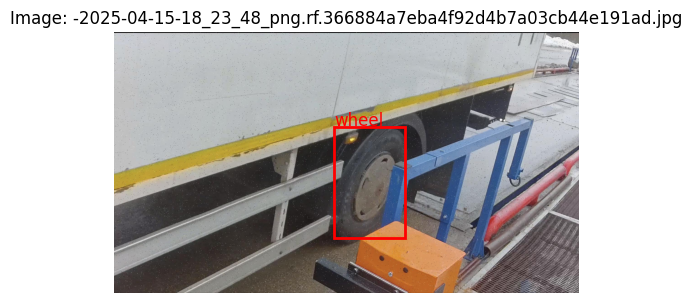

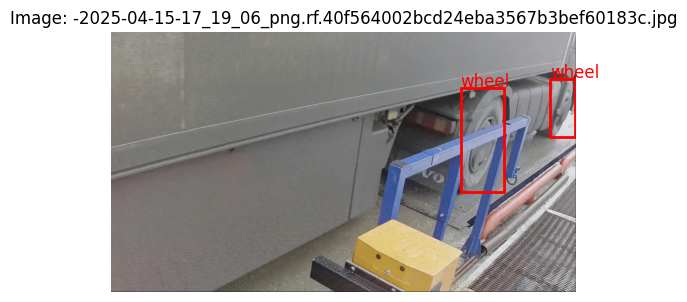

Val preview:


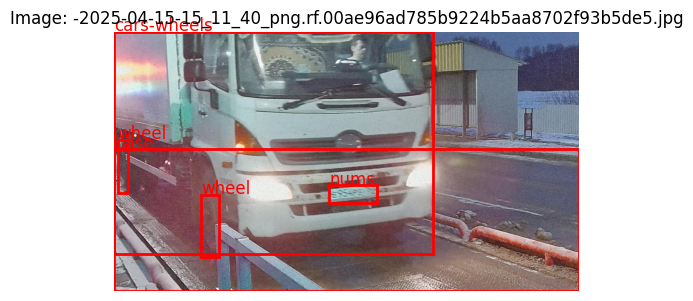

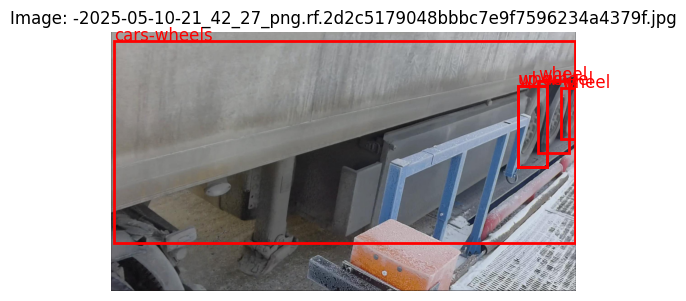

Test preview:


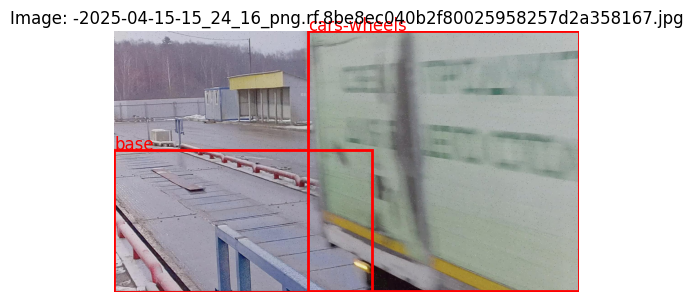

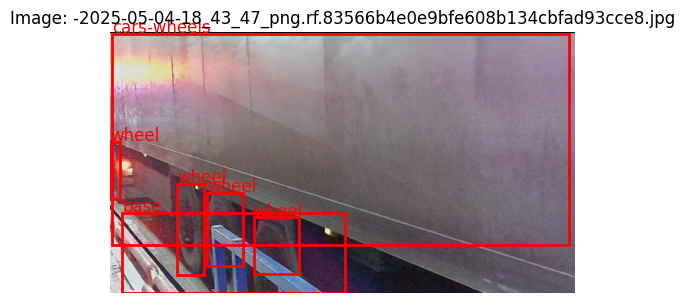

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_image_with_boxes(image_info, coco_dataset, images_dir):
    img_path = os.path.join(images_dir, image_info['file_name'])
    try:
        img = np.array(Image.open(img_path))
    except:
        img = np.ones((256, 256, 3), dtype=np.uint8) * 255  # Заглушка
    anns = [ann for ann in coco_dataset['annotations'] if ann['image_id'] == image_info['id']]
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    ax = plt.gca()
    for ann in anns:
        bbox = ann['segmentation']
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        cat_id = ann['category_id']
        cat_name = next((cat['name'] for cat in coco_dataset['categories'] if cat['id'] == cat_id), 'unknown')
        plt.text(bbox[0], bbox[1]-5, cat_name, color='red', fontsize=12)
    plt.title(f'Image: {image_info["file_name"]}')
    plt.axis('off')
    plt.show()

# Примеры для train/val/test
for ds, name in zip([train_coco, val_coco, test_coco], ['Train', 'Val', 'Test']):
    print(f"{name} preview:")
    for img_info in ds['images'][:2]:
        plot_image_with_boxes(img_info, ds, images_dir)

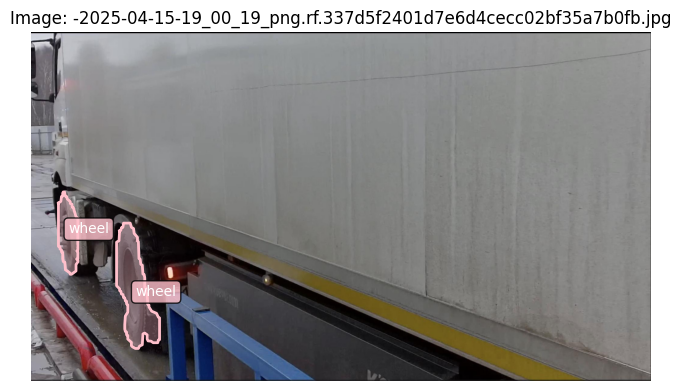

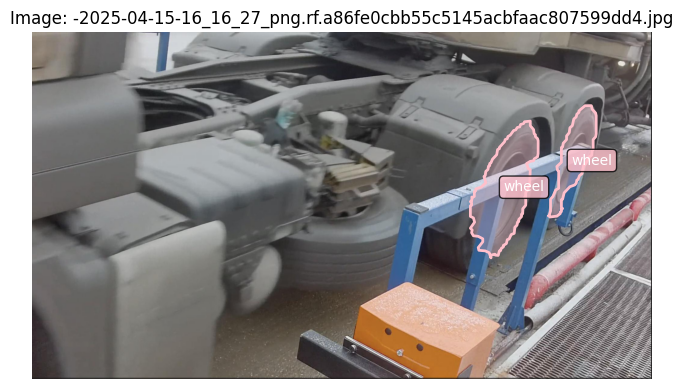

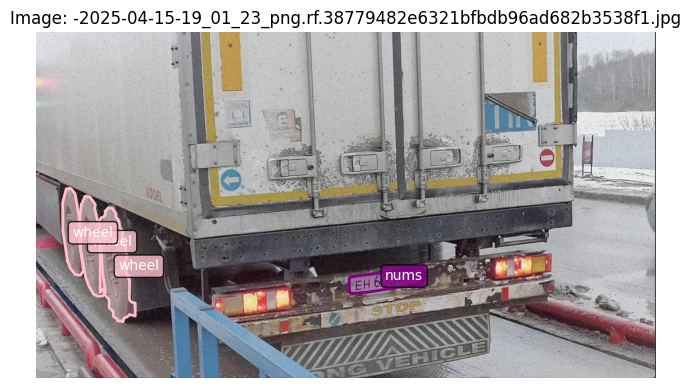

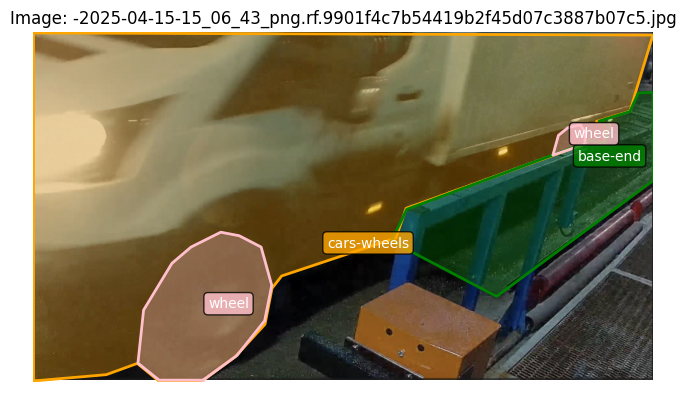

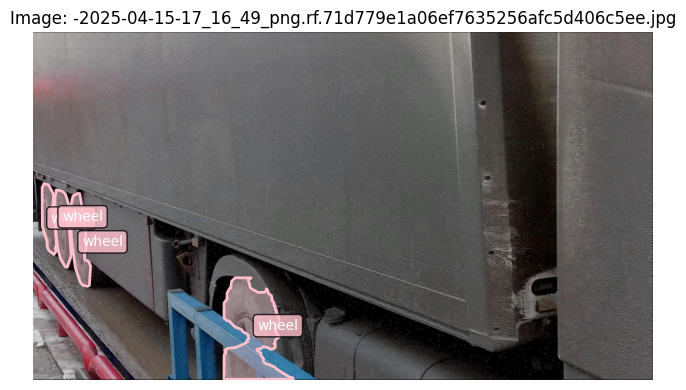

In [14]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
from pycocotools import mask as mask_utils

coco_annotation_path = '/kaggle/input/wheels3k-coco/train/_annotations.coco.json'
images_dir = '/kaggle/input/wheels3k-coco/train'

# Функция для визуализации сегментационных данных (обновленная)
def plot_image_with_segmentation(image_info, coco_dataset, images_dir):
    img_path = os.path.join(images_dir, image_info['file_name'])
    try:
        img = np.array(Image.open(img_path))
    except:
        img = np.ones((256, 256, 3), dtype=np.uint8) * 255  # Заглушка
    
    anns = [ann for ann in coco_dataset['annotations'] if ann['image_id'] == image_info['id']]
    
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    ax = plt.gca()
    
    for ann in anns:
        cat_id = ann['category_id']
        cat_name = next((cat['name'] for cat in coco_dataset['categories'] if cat['id'] == cat_id), 'unknown')
        
        # Определяем цвет в зависимости от категории
        color = get_color_for_category(cat_id)
        
        # Отрисовка сегментации
        if 'segmentation' in ann:
            seg = ann['segmentation']
            if isinstance(seg, list):  # полигон
                for poly in seg:
                    poly = np.array(poly).reshape((-1, 2))
                    ax.fill(poly[:, 0], poly[:, 1], alpha=0.3, color=color)
                    ax.plot(poly[:, 0], poly[:, 1], color=color, linewidth=2)
                    
                    # Вычисляем центр полигона для отображения метки
                    centroid = np.mean(poly, axis=0)
                    plt.text(centroid[0], centroid[1], cat_name, 
                             color='white', fontsize=10, 
                             bbox=dict(facecolor=color, alpha=0.8, boxstyle='round'))
            
    plt.title(f'Image: {image_info["file_name"]}')
    plt.axis('off')
    plt.show()

# Функция для определения цвета по категории
def get_color_for_category(cat_id):
    colors = [
        'red', 'blue', 'green', 'orange', 'purple', 
        'brown', 'pink', 'gray', 'cyan', 'magenta'
    ]
    return colors[cat_id % len(colors)]

# Код для разделения датасета (с учетом класса колес - id=6)
wheel_class_id = 6  # ID колес в COCO

def prepare_dataset_split(coco_annotation_path, images_dir):
    with open(coco_annotation_path, 'r') as f:
        coco_data = json.load(f)
    
    # Собираем id изображений с колесами
    wheel_image_ids = set(ann['image_id'] for ann in coco_data['annotations'] if ann['category_id'] == wheel_class_id)
    wheel_images = [img for img in coco_data['images'] if img['id'] in wheel_image_ids]
    non_wheel_images = [img for img in coco_data['images'] if img['id'] not in wheel_image_ids]
    
    # Разделение с балансом
    train_wheel, temp_wheel = train_test_split(wheel_images, test_size=0.2, random_state=42)
    val_wheel, test_wheel = train_test_split(temp_wheel, test_size=0.5, random_state=42)
    
    train_non_wheel, temp_non_wheel = train_test_split(non_wheel_images, test_size=0.2, random_state=42)
    val_non_wheel, test_non_wheel = train_test_split(temp_non_wheel, test_size=0.5, random_state=42)
    
    train_images = train_wheel + train_non_wheel
    val_images = val_wheel + val_non_wheel
    test_images = test_wheel + test_non_wheel
    
    def filter_annotations(images_list, annotations):
        image_ids = set(img['id'] for img in images_list)
        return [ann for ann in annotations if ann['image_id'] in image_ids]
    
    train_coco = {
        'images': train_images,
        'annotations': filter_annotations(train_images, coco_data['annotations']),
        'categories': coco_data['categories']
    }
    val_coco = {
        'images': val_images,
        'annotations': filter_annotations(val_images, coco_data['annotations']),
        'categories': coco_data['categories']
    }
    test_coco = {
        'images': test_images,
        'annotations': filter_annotations(test_images, coco_data['annotations']),
        'categories': coco_data['categories']
    }
    
    os.makedirs('/kaggle/working/wheels3k-coco/datasets', exist_ok=True)
    with open('/kaggle/working/wheels3k-coco/datasets/train_coco3k.json', 'w') as f:
        json.dump(train_coco, f)
    with open('/kaggle/working/wheels3k-coco/datasets/val_coco3k.json', 'w') as f:
        json.dump(val_coco, f)
    with open('/kaggle/working/wheels3k-coco/datasets/test_coco3k.json', 'w') as f:
        json.dump(test_coco, f)
    
    print(f"Train: {len(train_images)} images, Val: {len(val_images)} images, Test: {len(test_images)} images")
    print(f"Train wheels: {len(train_wheel)}, Val wheels: {len(val_wheel)}, Test wheels: {len(test_wheel)}")
    
    return train_coco, val_coco, test_coco

# Визуализация примеров датасета с сегментацией
def preview_dataset(coco_data, images_dir, num_samples=5):
    for i, img_info in enumerate(np.random.choice(coco_data['images'], 5, replace=False)):
        plot_image_with_segmentation(img_info, coco_data, images_dir)
        if i >= num_samples - 1:
            break

num_samples=5
for i, img_info in enumerate(np.random.choice(coco_data['images'], num_samples, replace=False)):
    plot_image_with_segmentation(img_info, coco_data, images_dir)
    if i >= num_samples - 1:
        break



In [15]:
# Пайплайн тренировки модели с улучшенной производительностью
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
import time
from torch.cuda.amp import autocast, GradScaler

class COCOSegmentationDataset(Dataset):
    def __init__(self, coco_json, img_dir, transform=None, target_class_id=6, cache_images=False):
        # Инициализация датасета со всеми необходимыми полями для сегментации
        self.coco_json = coco_json
        self.img_dir = img_dir
        self.transform = transform
        self.target_class_id = target_class_id
        self.cache_images = cache_images
        self.cached_imgs = {}
        
        with open(coco_json, 'r') as f:
            self.coco_data = json.load(f)
        
        self.images = self.coco_data['images']
        
        # Предзагрузка аннотаций для эффективного доступа
        self.image_id_to_anns = {}
        for ann in self.coco_data['annotations']:
            if ann['image_id'] not in self.image_id_to_anns:
                self.image_id_to_anns[ann['image_id']] = []
            self.image_id_to_anns[ann['image_id']].append(ann)
    
    def __len__(self):
        return len(self.images)
    
    def create_mask(self, anns, img_shape):
        h, w = img_shape[:2]
        mask = np.zeros((h, w), dtype=np.uint8)
        
        for ann in anns:
            if ann['category_id'] == self.target_class_id and 'segmentation' in ann:
                if isinstance(ann['segmentation'], list):  # Полигон
                    for seg in ann['segmentation']:
                        seg_array = np.array(seg).reshape(-1, 2)
                        pts = seg_array.astype(np.int32)
                        cv2.fillPoly(mask, [pts], 1)
                        
                elif isinstance(ann['segmentation'], dict):  # RLE
                    rle = ann['segmentation']
                    binary_mask = mask_utils.decode(rle)
                    mask = np.logical_or(mask, binary_mask).astype(np.uint8)
        
        return mask
    
    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_id = img_info['id']
        
        # Загрузка или получение из кэша
        if self.cache_images and img_id in self.cached_imgs:
            img = self.cached_imgs[img_id].copy()
        else:
            img_path = os.path.join(self.img_dir, img_info['file_name'])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.cache_images:
                self.cached_imgs[img_id] = img.copy()
        
        # Создание маски сегментации
        anns = self.image_id_to_anns.get(img_id, [])
        mask = self.create_mask(anns, img.shape)
        
        # Применение аугментаций
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        
        # Преобразование в тензоры
        img = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0
        mask = torch.from_numpy(mask).float().unsqueeze(0)
        
        return img, {'masks': mask, 'image_id': img_id}

# Основной класс для обучения модели с оптимизациями
class SegmentationTrainer:
    def __init__(self, model, train_loader, val_loader, config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=config['lr'],
            weight_decay=config['weight_decay']
        )
        
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=config['max_lr'],
            steps_per_epoch=len(train_loader),
            epochs=config['epochs']
        )
        
        self.scaler = GradScaler() if config['mixed_precision'] else None
        self.log_file = config['log_file']
        
        if os.path.exists(self.log_file):
            os.remove(self.log_file)
        
        self.best_iou = 0.0
        self.epochs_no_improve = 0
    
    def train_one_epoch(self):
        self.model.train()
        train_loss = 0
        start_time = time.time()
        
        for batch_idx, (imgs, targets) in enumerate(self.train_loader):
            imgs = imgs.to(self.device)
            masks = targets['masks'].to(self.device)
            
            # Mixed Precision Training
            if self.config['mixed_precision']:
                with autocast():
                    outputs = self.model(imgs)
                    loss = self.model.compute_loss(outputs, {'masks': masks})
                
                self.optimizer.zero_grad()
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                outputs = self.model(imgs)
                loss = self.model.compute_loss(outputs, {'masks': masks})
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
            self.scheduler.step()
            train_loss += loss.item()
            
            # Логирование прогресса
            if batch_idx % self.config['log_interval'] == 0:
                print(f"Batch {batch_idx}/{len(self.train_loader)}, Loss: {loss.item():.4f}")
        
        train_loss /= len(self.train_loader)
        epoch_time = time.time() - start_time
        
        return train_loss, epoch_time
    
    def validate(self, epoch, save_visualizations=True):
        self.model.eval()
        val_loss = 0
        val_iou = 0
        
        # Выбираем образцы для визуализации
        num_vis = min(4, len(self.val_loader.dataset))
        vis_indices = np.random.choice(len(self.val_loader.dataset), num_vis, replace=False)
        vis_samples = []
        
        with torch.no_grad():
            for batch_idx, (imgs, targets) in enumerate(self.val_loader):
                imgs = imgs.to(self.device)
                masks = targets['masks'].to(self.device)
                image_ids = targets['image_id']
                
                # Инференс
                if self.config['mixed_precision']:
                    with autocast():
                        outputs = self.model(imgs)
                        loss = self.model.compute_loss(outputs, {'masks': masks})
                else:
                    outputs = self.model(imgs)
                    loss = self.model.compute_loss(outputs, {'masks': masks})
                
                val_loss += loss.item()
                
                # Вычисление IoU
                pred_masks = outputs if not isinstance(outputs, dict) else outputs['masks']
                pred_masks = torch.sigmoid(pred_masks)
                batch_iou = self.compute_iou(pred_masks, masks)
                val_iou += batch_iou.item()
                
                # Сохранение образцов для визуализации
                for i in range(len(imgs)):
                    idx = batch_idx * self.val_loader.batch_size + i
                    if idx in vis_indices:
                        vis_samples.append({
                            'img': imgs[i].cpu(),
                            'gt_mask': masks[i].cpu(),
                            'pred_mask': pred_masks[i].cpu(),
                            'image_id': image_ids[i].item()
                        })
        
        val_loss /= len(self.val_loader)
        val_iou /= len(self.val_loader)
        
        # Визуализация примеров
        if save_visualizations and vis_samples:
            self.visualize_predictions(vis_samples, epoch)
        
        return val_loss, val_iou
    
    def compute_iou(self, pred_masks, gt_masks, threshold=0.5):
        pred_binary = (pred_masks > threshold).float()
        intersection = (pred_binary * gt_masks).sum(dim=[1, 2, 3])
        union = pred_binary.sum(dim=[1, 2, 3]) + gt_masks.sum(dim=[1, 2, 3]) - intersection
        iou = (intersection + 1e-8) / (union + 1e-8)
        return iou.mean()
    
    def visualize_predictions(self, samples, epoch):
        fig, axs = plt.subplots(len(samples), 3, figsize=(15, 5 * len(samples)))
        
        for i, sample in enumerate(samples):
            # Исходное изображение
            axs[i, 0].imshow(sample['img'].permute(1, 2, 0))
            axs[i, 0].set_title('Original Image')
            axs[i, 0].axis('off')
            
            # GT маска
            axs[i, 1].imshow(sample['img'].permute(1, 2, 0))
            axs[i, 1].imshow(sample['gt_mask'][0], alpha=0.5, cmap='Blues')
            axs[i, 1].set_title('Ground Truth Mask')
            axs[i, 1].axis('off')
            
            # Predicted маска
            axs[i, 2].imshow(sample['img'].permute(1, 2, 0))
            axs[i, 2].imshow(sample['pred_mask'][0], alpha=0.5, cmap='Reds')
            axs[i, 2].set_title('Predicted Mask')
            axs[i, 2].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'val_examples_epoch_{epoch}.png')
        plt.close()
    
    def log_metrics(self, epoch, train_loss, val_loss, val_iou, epoch_time):
        df = pd.DataFrame({
            'epoch': [epoch],
            'train_loss': [train_loss],
            'val_loss': [val_loss],
            'val_iou': [val_iou],
            'lr': [self.optimizer.param_groups[0]['lr']],
            'time': [epoch_time]
        })
        
        if epoch == 0:
            df.to_csv(self.log_file, index=False)
        else:
            df.to_csv(self.log_file, mode='a', header=False, index=False)
    
    def plot_training_curves(self):
        data = pd.read_csv(self.log_file)
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
        
        # График потерь
        ax1.plot(data['epoch'], data['train_loss'], label='Train Loss')
        ax1.plot(data['epoch'], data['val_loss'], label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        
        # График IoU
        ax2.plot(data['epoch'], data['val_iou'], label='Val IoU')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('IoU')
        ax2.set_title('Validation IoU')
        ax2.legend()
        
        # График Learning Rate
        ax3.plot(data['epoch'], data['lr'])
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_title('Learning Rate Schedule')
        
        plt.tight_layout()
        plt.savefig('training_curves.png')
        plt.close()
    
    def save_checkpoint(self, epoch, val_iou):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_iou': val_iou
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pt')
        
        # Сохраняем лучшую модель
        if val_iou > self.best_iou:
            self.best_iou = val_iou
            self.epochs_no_improve = 0
            torch.save(self.model.state_dict(), 'best_model.pt')
            print(f"New best model saved with IoU: {val_iou:.4f}")
        else:
            self.epochs_no_improve += 1
    
    def train(self):
        for epoch in range(self.config['epochs']):
            print(f"\nEpoch {epoch+1}/{self.config['epochs']}")
            
            # Обучение
            train_loss, epoch_time = self.train_one_epoch()
            print(f"Train Loss: {train_loss:.4f}, Time: {epoch_time:.2f}s")
            
            # Валидация
            val_loss, val_iou = self.validate(epoch)
            print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")
            
            # Логирование
            self.log_metrics(epoch, train_loss, val_loss, val_iou, epoch_time)
            
            # Визуализация графиков
            self.plot_training_curves()
            
            # Сохранение чекпойнта
            self.save_checkpoint(epoch, val_iou)
            
            # Early stopping
            if self.epochs_no_improve >= self.config['patience']:
                print(f"No improvement for {self.config['patience']} epochs. Early stopping.")
                break

# Пример вызова кода для обучения
def train_yolo_segmentation_model(train_coco, val_coco, images_dir):
    # Гиперпараметры
    config = {
        'lr': 1e-4,
        'max_lr': 3e-4,
        'weight_decay': 0.05,
        'epochs': 100,
        'patience': 10,
        'mixed_precision': True,
        'log_interval': 10,
        'log_file': '/kaggle/working/wheels3k-coco/training_log.csv'
    }
    
    # Загрузка модели YOLOv11
    model = YOLOv11('yolov11n-seg.pt')
    
    # Создание датасетов
    train_dataset = COCOSegmentationDataset(
        '/kaggle/working/wheels3k-coco/datasets/train_coco3k.json',
        images_dir,
        target_class_id=6,  # wheel_class_id
        cache_images=True
    )
    
    val_dataset = COCOSegmentationDataset(
        '/kaggle/working/wheels3k-coco/datasets/val_coco3k.json',
        images_dir,
        target_class_id=6
    )
    
    # Создание загрузчиков данных
    train_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    # Инициализация тренера
    trainer = SegmentationTrainer(model, train_loader, val_loader, config)
    
    # Запуск обучения
    trainer.train()
    
    return model


In [2]:
import os
import json
import random
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.cuda.amp import autocast, GradScaler
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

# 1. Разделение датасета по тегам 'start' и 'end' (80/10/10)
coco_path = '/kaggle/input/wheels3k-coco/train/_annotations.coco.json'
images_dir = '/kaggle/input/wheels3k-coco/train'

with open(coco_path, 'r') as f:
    coco = json.load(f)

def filter_by_tag(imgs, tag):
    return [img for img in imgs
            if 'extra' in img 
            and 'user_tags' in img['extra'] 
            and tag in img['extra']['user_tags']]

start_imgs = filter_by_tag(coco['images'], 'start')
end_imgs   = filter_by_tag(coco['images'], 'end')

def split(imgs):
    tr, v = train_test_split(imgs, test_size=0.2, random_state=42)
    v, te = train_test_split(v, test_size=0.5, random_state=42)
    return tr, v, te

train_start, val_start, test_start = split(start_imgs)
train_end,   val_end,   test_end   = split(end_imgs)

train_imgs = train_start + train_end
val_imgs   = val_start   + val_end

def filter_anns(imgs):
    ids = set(i['id'] for i in imgs)
    return [a for a in coco['annotations'] if a['image_id'] in ids]

splits = {
    'train': (train_imgs, filter_anns(train_imgs)),
    'val':   (val_imgs,   filter_anns(val_imgs)),
    'test_start': (test_start, filter_anns(test_start)),
    'test_end':   (test_end,   filter_anns(test_end))
}

os.makedirs('/kaggle/working/wheels3k-coco/datasets', exist_ok=True)
for name, (imgs, anns) in splits.items():
    out = {'images': imgs, 'annotations': anns, 'categories': coco['categories']}
    with open(f'/kaggle/working/wheels3k-coco/datasets/{name}.json','w') as f:
        json.dump(out, f)



2025-05-14 23:59:45.590141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747267185.613136     238 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747267185.620148     238 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


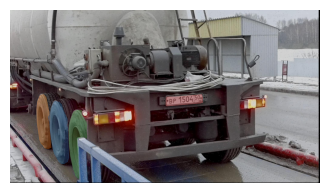

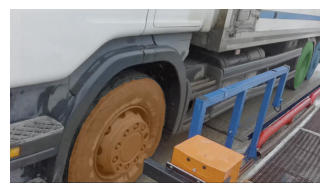

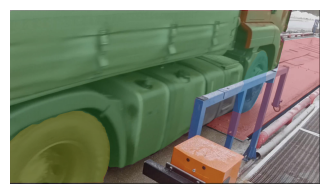

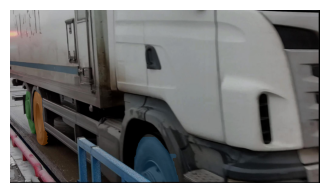

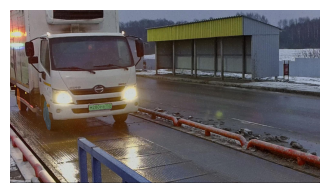

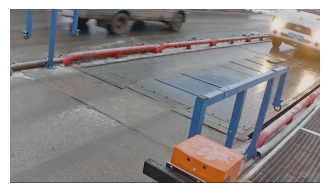

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_masks_safe(img_info, ds, images_dir):
    """
    Загружает изображение через PIL и рисует сегментационные маски из COCO-датасета.
    """
    img_path = os.path.join(images_dir, img_info['file_name'])
    try:
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)
    except Exception as e:
        print(f"Warning: Cannot load {img_path}: {e}")
        img = np.ones((256,256,3), dtype=np.uint8) * 255

    anns = [ann for ann in ds['annotations'] if ann['image_id']==img_info['id']]
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    ax = plt.gca()
    for ann in anns:
        if 'segmentation' not in ann: continue
        seg = ann['segmentation']
        if isinstance(seg, list):
            for poly in seg:
                pts = np.array(poly).reshape(-1,2)
                ax.fill(pts[:,0], pts[:,1], alpha=0.3)
    plt.axis('off')
    plt.show()

import json, random

# Загрузите ваш COCO JSON (например, datasets/val.json)
ds_path = '/kaggle/working/wheels3k-coco/datasets/val.json'
with open(ds_path, 'r') as f:
    ds = json.load(f)

for img_info in random.sample(ds['images'], min(6, len(ds['images']))):
    plot_masks_safe(img_info, ds, images_dir)

In [6]:
# 3. Dataset с фильтрацией по тегу и одной маской (start OR end)
class MultiHeadDataset(Dataset):
    def __init__(self, split_name):
        data = json.load(open(f'/kaggle/working/wheels3k-coco/datasets/{split_name}.json'))
        self.images = data['images']
        self.anns_by_img = {}
        for a in data['annotations']:
            self.anns_by_img.setdefault(a['image_id'],[]).append(a)
        self.cat_id = 6
    def __len__(self):
        return len(self.images)
    def __getitem__(self, i):
        info = self.images[i]
        img = cv2.cvtColor(cv2.imread(os.path.join(images_dir,info['file_name'])),
                           cv2.COLOR_BGR2RGB)
        h,w = img.shape[:2]
        # view: start=1, end=0
        view = 1 if 'start' in info['extra']['user_tags'] else 0
        mask = np.zeros((h,w),np.uint8)
        for a in self.anns_by_img.get(info['id'],[]):
            if a['category_id']==self.cat_id:
                for poly in a['segmentation']:
                    pts = np.array(poly).reshape(-1,2).astype(int)
                    cv2.fillPoly(mask,[pts],1)
        img_t = torch.from_numpy(img).permute(2,0,1).float()/255
        mask_t = torch.from_numpy(mask)[None].float()
        return img_t, view, mask_t


In [21]:
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
import json
import os

class MultiHeadDataset(Dataset):
    def __init__(self, split_name, images_dir=images_dir, target_size=(1024, 608)):
        """
        split_name: 'train', 'val' и т.д.
        images_dir: папка с изображениями
        target_size: (width, height)
        """
        data = json.load(open(f'/kaggle/working/wheels3k-coco/datasets/{split_name}.json'))
        self.images = data['images']
        self.anns_by_img = {}
        for a in data['annotations']:
            self.anns_by_img.setdefault(a['image_id'], []).append(a)
        self.cat_id = 6
        self.images_dir = images_dir
        self.target_size = target_size  # (W, H)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
        info = self.images[i]
        img_path = os.path.join(self.images_dir, info['file_name'])
        # 1) Загрузка и конвертация в RGB
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # 2) Сбор и отрисовка маски
        mask = np.zeros((h, w), dtype=np.uint8)
        for a in self.anns_by_img.get(info['id'], []):
            if a['category_id'] == self.cat_id:
                for poly in a['segmentation']:
                    pts = np.array(poly).reshape(-1, 2).astype(int)
                    cv2.fillPoly(mask, [pts], 1)

        # 3) Определяем view: start=1, end=0
        view = 1 if 'start' in info['extra']['user_tags'] else 0

        # 4) Приводим к единому размеру
        target_w, target_h = self.target_size
        img = cv2.resize(img, (target_w, target_h), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (target_w, target_h), interpolation=cv2.INTER_NEAREST)

        # 5) В тензоры
        img_t  = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        mask_t = torch.from_numpy(mask)[None].float()

        return img_t, view, mask_t

In [9]:
!pip install ultralytics
import ultralytics
from ultralytics import YOLO
print("Ultralytics version:", ultralytics.__version__)  # Должно вывести что-то вроде 8.x.x

Ultralytics version: 8.3.134


In [68]:
class MultiHeadModel(nn.Module):
    def __init__(self, backbone='yolo11n-seg.pt'):
        super().__init__()
        self.yolo = YOLO(backbone)
        # hook
        self._feat = None
        layer = self.yolo.model.model[-2]
        layer.register_forward_hook(lambda m,i,o: setattr(self,'_feat',o))
        # dummy
        with torch.no_grad():
            _ = self.yolo.model(torch.zeros(1,3,1024,608))
        C = self._feat.shape[1]
        self.view_head = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                       nn.Flatten(), nn.Linear(C,2))
        self.seg_end   = nn.Conv2d(C,1,1)
        self.seg_start = nn.Conv2d(C,1,1)
        # детекционная голова (копия YOLO Detect)
        self.detect = self.yolo.model.model[-1]

    def forward(self, x):
        # 1) фичи + detect
        _ = self.yolo.model(x)     # backbone->feat->detect
        feats = self._feat
        # 2) view
        view_logits = self.view_head(feats)
        # 3) seg
        seg_e = torch.sigmoid(F.interpolate(self.seg_end(feats), size=x.shape[2:],mode='bilinear'))
        seg_s = torch.sigmoid(F.interpolate(self.seg_start(feats), size=x.shape[2:],mode='bilinear'))
        # 4) detect predictions
        det_out = self.detect(feats)  # [B, anchors, (x,y,w,h,obj,cls...)]
        return {'view':view_logits, 'seg': [seg_e,seg_s], 'det': det_out}

    def train(self, mode=True):
            # переопределяем, чтобы не звать Ultralytics.train()
            super().train(mode)
            for m in [self.backbone, self.view_head, self.seg_end, self.seg_start, self.detect_head]:
                m.train(mode)
            return self

    

In [66]:
class MultiHeadModel(nn.Module):
    def __init__(self, ckpt='yolo11n-seg.pt'):
        super().__init__()
        y = YOLO(ckpt).model.model  # nn.ModuleList
        # делим на backbone и detect_head
        self.backbone   = nn.Sequential(*y[:-1])  # всё кроме последнего Detect
        self.detect_head=    y[-1]                # последний модуль YOLO Detect

        # dummy-прогон, чтобы узнать C
        self.backbone.eval()
        with torch.no_grad():
            f = self.backbone(torch.zeros(1,3,*self.backbone[0].stride*2 if hasattr(self.backbone[0],'stride') else (640,640)))
        C = f.shape[1]

        # view‐head
        self.view_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(C, 2)
        )
        # seg‐heads
        self.seg_end   = nn.Conv2d(C,1,1)
        self.seg_start = nn.Conv2d(C,1,1)

    def forward(self, x):
        feats = self.backbone(x)       # [B,C,Hf,Wf]
        # detect
        det_out = self.detect_head(feats)  # [B, anchors, no]

        # view
        view_logits = self.view_head(feats)

        # seg
        s0 = torch.sigmoid(F.interpolate(self.seg_end(feats), size=x.shape[2:], mode='bilinear'))
        s1 = torch.sigmoid(F.interpolate(self.seg_start(feats), size=x.shape[2:], mode='bilinear'))

        return {'det': det_out, 'view': view_logits, 'seg': [s0, s1]}

    def train(self, mode=True):
        # переопределяем, чтобы не звать Ultralytics.train()
        super().train(mode)
        for m in [self.backbone, self.view_head, self.seg_end, self.seg_start, self.detect_head]:
            m.train(mode)
        return self

In [69]:
model = YOLO('yolo11n-seg.pt')  
model = MultiHeadModel().cuda()

In [48]:
model = MultiHeadModel().cuda()

AttributeError: 'MultiHeadModel' object has no attribute 'yolo'

/tmp/ipykernel_238/1236731759.py:139: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


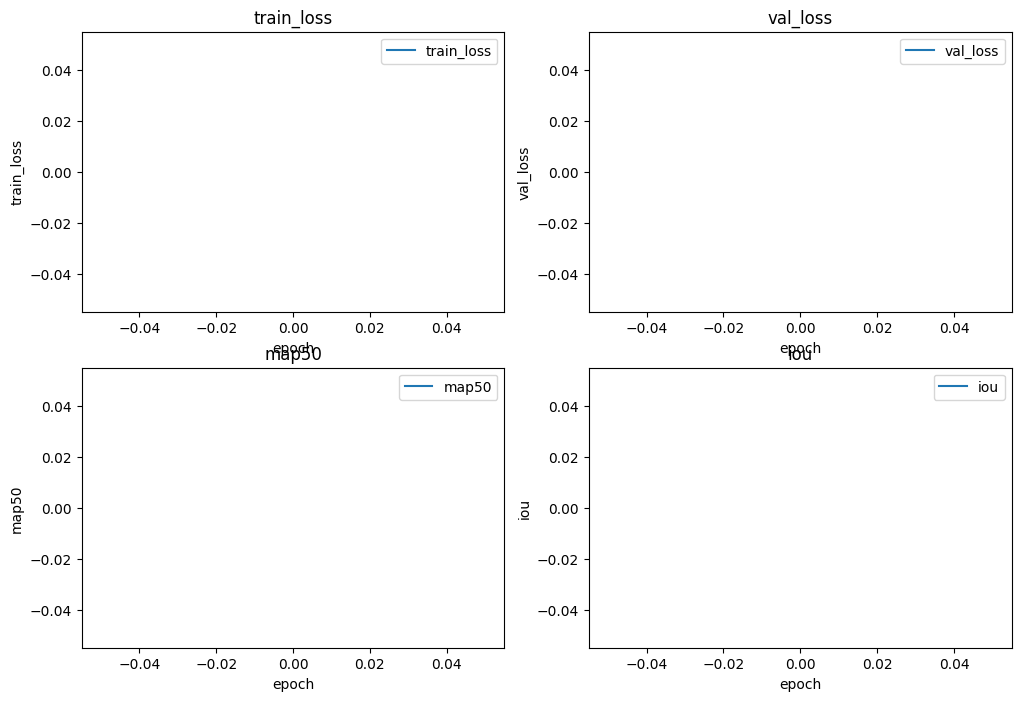

TypeError: 'bool' object is not callable

In [71]:
ce    = nn.CrossEntropyLoss()
bce   = nn.BCEWithLogitsLoss()
def dice(p, g):
    i = (p*g).sum((1,2,3))
    u = p.sum((1,2,3)) + g.sum((1,2,3))
    return 1 - ((2*i+1e-6)/(u+1e-6)).mean()

def det_loss_fn(det_out, masks):
    # objectness only: pred[...,4], target=1 если в маске хоть 1 пикс.
    obj_pred = det_out[...,4]
    obj_tgt  = (masks.view(masks.size(0), -1).sum(1)>0).float()
    p = torch.sigmoid(obj_pred)
    # focal
    alpha, gamma = 0.25, 2.0
    pt = obj_tgt*p + (1-obj_tgt)*(1-p)
    w = alpha*obj_tgt + (1-alpha)*(1-obj_tgt)
    w = w * (1-pt).pow(gamma)
    return F.binary_cross_entropy(p, obj_tgt, weight=w)

def compute_losses(out, views, masks):
    vloss = ce(out['view'], views)
    # seg по правильной голове
    sel   = torch.stack([out['seg'][v][i] for i,v in enumerate(views)], 0)[:,None]
    sloss = bce(sel, masks) + dice(sel, masks)
    dloss = det_loss_fn(out['det'], masks)
    total = vloss + sloss + dloss
    return {'total': total, 'view': vloss.item(), 'seg': sloss.item(), 'det': dloss.item()}

def compute_metrics(out, views, masks):
    # view_acc
    view_acc = (out['view'].argmax(1)==views).float().mean().item()
    # IoU
    sel = torch.stack([out['seg'][v][i] for i,v in enumerate(views)],0)[:,None]>0.5
    i = (sel & (masks>0.5)).sum().float()
    u = (sel | (masks>0.5)).sum().float()
    iou= ((i+1e-6)/(u+1e-6)).item()
    # map50, prec, rec можно добавить свой evaluation
    return {'view_acc': view_acc, 'iou': iou, 'map50':0., 'prec':0., 'rec':0.}

# ------------------------------------------------------------------------------
# 4) Logger, Plotter, Viz
# ------------------------------------------------------------------------------
class MetricsLogger:
    def __init__(self, path):
        self.path = path; self.rows=[]
        if os.path.exists(path): os.remove(path)
    def log(self, ep, m):
        row={'epoch':ep}; row.update(m)
        self.rows.append(row)
        pd.DataFrame(self.rows).to_csv(self.path, index=False)

class LivePlotter:
    def __init__(self, keys):
        self.keys = keys
        self.data = {k:[] for k in keys}
        plt.ion()
        self.fig, axs = plt.subplots(2,2, figsize=(12,8))
        self.axs = axs.flatten()
        self.lines = {}
        for i,k in enumerate(keys):
            ax = self.axs[i]
            ax.set_title(k); ax.set_xlabel('epoch'); ax.set_ylabel(k)
            self.lines[k], = ax.plot([], [], label=k)
            ax.legend()
        plt.show()
    def update(self, ep, m):
        for k in self.keys:
            if k in m:
                self.data[k].append(m[k])
                idx = self.keys.index(k)
                self.lines[k].set_data(range(len(self.data[k])), self.data[k])
                ax = self.axs[idx]; ax.relim(); ax.autoscale()
        self.fig.canvas.draw(); self.fig.canvas.flush_events()

def show_random(imgs, masks, preds, n=4):
    idxs = random.sample(range(len(imgs)), n)
    fig,axs = plt.subplots(n,3,figsize=(12,4*n))
    for i,j in enumerate(idxs):
        im = imgs[j].permute(1,2,0).cpu().numpy()
        gt = masks[j,0].cpu().numpy()
        pm = preds[j,0].cpu().numpy()>0.5
        axs[i,0].imshow(im); axs[i,0].axis('off'); axs[i,0].set_title('img')
        axs[i,1].imshow(im); axs[i,1].imshow(gt,alpha=0.5,cmap='spring'); axs[i,1].axis('off'); axs[i,1].set_title('gt')
        axs[i,2].imshow(im); axs[i,2].imshow(pm,alpha=0.5,cmap='winter'); axs[i,2].axis('off'); axs[i,2].set_title('pred')
    plt.show()

# ------------------------------------------------------------------------------
# 5) Train/Val Loops
# ------------------------------------------------------------------------------
def train_epoch(model, loader, opt, scaler):
    model.train()
    L = {'total':0,'view':0,'seg':0,'det':0}
    for imgs,views,masks in loader:
        imgs,views,masks = imgs.cuda(),views.cuda(),masks.cuda()
        opt.zero_grad()
        with autocast():
            out = model(imgs)
            losses = compute_losses(out, views, masks)
        scaler.scale(losses['total']).backward()
        scaler.step(opt); scaler.update()
        for k in ['total','view','seg','det']:
            L[k] += losses[k] if isinstance(losses[k], float) else losses[k].item()
    return {k:L[k]/len(loader) for k in L}

def val_epoch(model, loader):
    model.eval()
    M = {'view_acc':0,'iou':0,'map50':0,'prec':0,'rec':0,'det':0,'seg':0,'view':0,'total':0}
    cnt=0; imgs_b,mask_b,pred_b=[],[],[]
    with torch.no_grad():
        for imgs,views,masks in loader:
            imgs,views,masks = imgs.cuda(),views.cuda(),masks.cuda()
            out = model(imgs)
            losses = compute_losses(out,views,masks)
            mets   = compute_metrics(out,views,masks)
            for k in ['view','seg','det','total']:
                M[k] += losses[k] if isinstance(losses[k], float) else losses[k].item()
            for k in ['view_acc','iou','map50','prec','rec']:
                M[k] += mets[k]
            cnt+=1
            imgs_b.append(imgs.cpu()); mask_b.append(masks.cpu())
            sel = torch.stack([out['seg'][v][i] for i,v in enumerate(views)],0)[:,None]
            pred_b.append(sel.cpu())
    for k in M: M[k]/=cnt
    return M, torch.cat(imgs_b), torch.cat(mask_b), torch.cat(pred_b)

# ------------------------------------------------------------------------------
# 6) Запуск обучения
# ------------------------------------------------------------------------------
train_ds = MultiHeadDataset('train')
val_ds   = MultiHeadDataset('val')

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=4)

model  = MultiHeadModel().cuda()
opt    = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
sched  = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
            steps_per_epoch=len(train_loader), epochs=30, pct_start=0.2)
scaler = GradScaler()
writer = SummaryWriter('/kaggle/working/wheels3k-coco/runs/wheel')
logger = MetricsLogger('/kaggle/working/wheels3k-coco/runs/wheel/metrics.csv')
plotter= LivePlotter(['train_loss','val_loss','map50','iou'])

best_map = 0
os.makedirs('/kaggle/working/wheels3k-coco/runs/wheel/checkpoints', exist_ok=True)
for ep in range(30):
    trm = train_epoch(model, train_loader, opt, scaler)
    M, imgs_b, mask_b, pred_b = val_epoch(model, val_loader)
    # Лог
    metrics = {
        'train_loss': trm['total'],
        'val_loss':   M['total'],
        'map50':      M['map50'],
        'iou':        M['iou']
    }
    logger.log(ep, metrics)
    plotter.update(ep, metrics)
    # Показываем 4 примера
    show_random(imgs_b, mask_b, pred_b, n=4)
    # LR & чекпоинты
    writer.add_scalar('lr', sched.get_last_lr()[0], ep)
    sched.step()
    ck=f'runs/wheel/checkpoints/ep{ep}_map{M["map50"]:.3f}.pt'
    torch.save(model.state_dict(), ck)
    if M['map50']>best_map:
        best_map=M['map50']
        torch.save(model.state_dict(), '/kaggle/working/wheels3k-coco/runs/wheel/checkpoints/best.pt')

In [39]:
ce    = nn.CrossEntropyLoss()
bce   = nn.BCEWithLogitsLoss()
foc   = lambda p,t: (t*(1-p)**2*torch.log(p+1e-9)).mean()*-1  # focal

def det_loss_fn(det_pred, targets):
    # det_pred: [B, nx, no] → распарсить по xywh,obj,cls
    # targets: можно взять из mask→bbox.
    # Для простоты считаем только objectness loss:
    obj_pred = det_pred[...,4]
    obj_tgt  = (targets.sum((2,3))>0).float()  # если на картинке есть колёса
    return foc(torch.sigmoid(obj_pred), obj_tgt)

def compute_losses(output, views, masks):
    # view
    vloss = ce(output['view'], views)
    # seg
    sel   = torch.stack([output['seg'][v][i] for i,v in enumerate(views)],0)[:,None]
    gloss = bce(sel, masks) + (1 - ((2*(sel*masks).sum((1,2,3))+1e-6)/(sel.sum((1,2,3))+masks.sum((1,2,3))+1e-6))).mean()
    # det
    dloss = det_loss_fn(output['det'], masks)
    total = vloss + gloss + dloss
    return {'total': total, 'view': vloss.item(), 'seg': gloss.item(), 'det': dloss.item()}

def compute_metrics(output, views, masks):
    # view acc
    view_acc = (output['view'].argmax(1)==views).float().mean().item()
    # iou
    sel      = torch.stack([output['seg'][v][i] for i,v in enumerate(views)],0)[:,None]>0.5
    inter    = (sel & (masks>0.5)).sum().float()
    union    = (sel | (masks>0.5)).sum().float()
    iou      = ((inter+1e-6)/(union+1e-6)).item()
    # mAP, prec, rec – по выходам det Pred → пропускаем, или используем внешнюю evaluate()
    map50, prec, rec = 0.0, 0.0, 0.0
    return {'view_acc':view_acc, 'iou':iou, 'map50':map50,'prec':prec,'rec':rec}

# ----------------------
# 4) Train/Val loops + Logger + Plotter + Viz
# ----------------------
class MetricsLogger:
    def __init__(self, path):
        self.path = path; self.rows=[]
        if os.path.exists(path): os.remove(path)
    def log(self, epoch, m):
        row={'epoch':epoch}; row.update(m)
        self.rows.append(row); pd.DataFrame(self.rows).to_csv(self.path,index=False)

class LivePlotter:
    def __init__(self, keys):
        self.keys=keys; self.data={k:[] for k in keys}
        plt.ion(); self.fig, self.axs=plt.subplots(2,2,figsize=(10,8))
        self.axs=self.axs.flatten(); self.lines={}
        for i,k in enumerate(keys):
            ax=self.axs[i]; ax.set_title(k); ax.set_xlabel('epoch'); ax.set_ylabel(k)
            self.lines[k],=ax.plot([],[])
        plt.show()

    def update(self, epoch, m):
        for k in self.keys:
            if k in m:
                self.data[k].append(m[k])
                ln=self.lines[k]; ln.set_data(range(len(self.data[k])), self.data[k])
                ax=self.axs[self.keys.index(k)]; ax.relim(); ax.autoscale()
        self.fig.canvas.draw(); self.fig.canvas.flush_events()

def show_random(imgs, masks, preds, n=4):
    idxs = random.sample(range(len(imgs)), n)
    fig, axs = plt.subplots(n,3,figsize=(12,4*n))
    for i,j in enumerate(idxs):
        im=imgs[j].permute(1,2,0).cpu().numpy()
        gt=masks[j,0].cpu().numpy(); pm=preds[j,0].cpu().numpy()>0.5
        axs[i,0].imshow(im); axs[i,0].set_title('img'); axs[i,0].axis('off')
        axs[i,1].imshow(im); axs[i,1].imshow(gt,alpha=0.5,cmap='spring'); axs[i,1].axis('off')
        axs[i,2].imshow(im); axs[i,2].imshow(pm,alpha=0.5,cmap='winter'); axs[i,2].axis('off')
    plt.show()


/tmp/ipykernel_238/3787096913.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


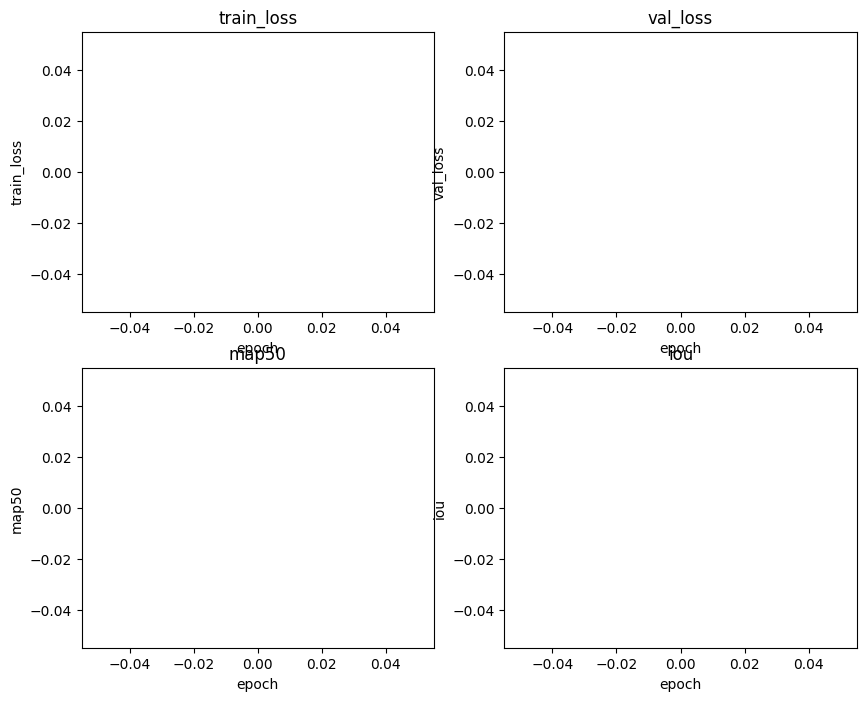

TypeError: 'bool' object is not callable

In [40]:
# DataLoader
train_ds = MultiHeadDataset('train')
val_ds   = MultiHeadDataset('val')
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)

# Init
model  = MultiHeadModel().cuda()
opt    = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
sched  = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=100)
scaler = GradScaler()
logger = MetricsLogger('/kaggle/working/wheels3k-coco/metrics.csv')
plotter= LivePlotter(['train_loss','val_loss','map50','iou'])

best_map = 0
for e in range(30):
    # train
    tl=0
    model.train()
    for imgs,views,masks in train_loader:
        imgs,views,masks=imgs.cuda(),views.cuda(),masks.cuda()
        opt.zero_grad()
        with autocast():
            out = model(imgs)
            losses = compute_losses(out,views,masks)
        scaler.scale(losses['total']).backward()
        scaler.step(opt); scaler.update()
        tl += losses['total'].item()
        sched.step()
    train_loss = tl/len(train_loader)

    # val
    model.eval(); vl=0
    all_iou=0; all_map=0
    imgs_b,mask_b,pred_b=[],[],[]
    with torch.no_grad():
        for imgs,views,masks in val_loader:
            imgs,views,masks=imgs.cuda(),views.cuda(),masks.cuda()
            out = model(imgs)
            losses = compute_losses(out,views,masks)
            vl += losses['total'].item()
            mets = compute_metrics(out,views,masks)
            all_iou += mets['iou']; all_map += mets['map50']
            imgs_b.append(imgs.cpu()); mask_b.append(masks.cpu())
            sel = torch.stack([out['seg'][v][i] for i,v in enumerate(views)],0)[:,None]
            pred_b.append(sel.cpu())
    val_loss = vl/len(val_loader)
    mean_iou=all_iou/len(val_loader)
    mean_map=all_map/len(val_loader)

    # log + plot
    metrics = {'train_loss':train_loss,'val_loss':val_loss,'map50':mean_map,'iou':mean_iou}
    logger.log(e, metrics)
    plotter.update(e, metrics)

    # show
    imgs_cat  = torch.cat(imgs_b,0); mask_cat = torch.cat(mask_b,0); pred_cat=torch.cat(pred_b,0)
    show_random(imgs_cat, mask_cat, pred_cat, n=4)

    # checkpoint
    ck=f'/kaggle/working/wheels3k-coco/checkpoints/ep{e}_map{mean_map:.3f}.pt'
    os.makedirs('/kaggle/working/wheels3k-coco/checkpoints',exist_ok=True)
    torch.save(model.state_dict(), ck)
    if mean_map>best_map:
        best_map=mean_map
        torch.save(model.state_dict(), '/kaggle/working/wheels3k-coco/checkpoints/best.pt')

In [23]:
# 3) Loss & metрики
ce  = nn.CrossEntropyLoss()
bce = nn.BCEWithLogitsLoss()
def dice(pred,gt):
    I = (pred*gt).sum((1,2,3)); U=pred.sum((1,2,3))+gt.sum((1,2,3))
    return 1-((2*I+1e-6)/(U+1e-6)).mean()

def compute_metrics(pred,view_true,mask_true):
    # детекция → loss + mAP, prec, rec (имплементируйте evaluate_yolo по вашим данным)
    # det_loss, map50,prec,rec = evaluate_yolo(pred['det'], mask_true)
    map50,prec,rec,det_loss = 0,0,0,0
    view_acc = (pred['view'].argmax(1)==view_true).float().mean().item()
    sel = torch.stack([pred['seg'][v][i] for i,v in enumerate(view_true)],0)[:,None]
    sl = bce(sel,mask_true)+dice(sel,mask_true)
    return map50,prec,rec,det_loss,view_acc,sl.item()

# 4) Train/Val loop
def train_epoch(m,loader,opt,scaler,writer,ep):
    m.train()
    L = {'total':0,'det':0,'view':0,'seg':0}
    for i,(imgs,views,masks) in enumerate(loader):
        imgs,views,masks = imgs.cuda(),views.cuda(),masks.cuda()
        opt.zero_grad()
        with autocast():
            o = m(imgs)
            # детекционный лосс
            det_loss = m.yolo.model.loss(o['det'], imgs, masks)['total']
            v_loss   = ce(o['view'], views)
            sel = torch.stack([o['seg'][v][j] for j,v in enumerate(views)],0)[:,None]
            s_loss = bce(sel,masks) + dice(sel,masks)
            total = det_loss + v_loss + s_loss
        scaler.scale(total).backward()
        scaler.step(opt); scaler.update()
        writer.add_scalar('train/total', total.item(), ep*len(loader)+i)
        L['total']+= total.item()
        L['det']  += det_loss.item()
        L['view'] += v_loss.item()
        L['seg']  += s_loss.item()
    return {k:L[k]/len(loader) for k in L}

@torch.no_grad()
def val_epoch(m,loader,writer,ep):
    m.eval()
    M = np.zeros(6); n=0
    for imgs,views,masks in loader:
        imgs,views,masks = imgs.cuda(),views.cuda(),masks.cuda()
        o = m(imgs)
        vals = compute_metrics(o,views,masks)
        M += np.array(vals); n+=1
    M/=n
    names = ['map50','prec','rec','det_loss','view_acc','seg_loss']
    for nm,v in zip(names,M):
        writer.add_scalar('val/'+nm, v, ep)
    return dict(zip(names,M))

# 5) Main
train_ds = MultiHeadDataset('train')
val_ds   = MultiHeadDataset('val')
tr = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4)
vl = DataLoader(val_ds,   batch_size=8, shuffle=False,num_workers=4)

model  = MultiHeadModel().cuda()
opt    = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
sched  = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
            steps_per_epoch=len(tr), epochs=30, pct_start=0.2)
scaler = GradScaler()
writer = SummaryWriter('/kaggle/working/wheels3k-coco/runs/wheel')

best_map = 0
os.makedirs('/kaggle/working/wheels3k-coco/checkpoints', exist_ok=True)
for ep in range(30):
    L = train_epoch(model,tr,opt,scaler,writer,ep)
    M = val_epoch(model,vl,writer,ep)
    writer.add_scalar('lr', sched.get_last_lr()[0], ep)
    sched.step()
    ck = f'checkpoints/epoch{ep}_map{M["map50"]:.3f}.pt'
    torch.save(model.state_dict(), ck)
    if M['map50']>best_map:
        best_map = M['map50']
        torch.save(model.state_dict(), '/kaggle/working/wheels3k-coco/checkpoints/best.pt')

/tmp/ipykernel_238/2692219609.py:66: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_238/2692219609.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


TypeError: BaseModel.loss() takes from 2 to 3 positional arguments but 4 were given

In [35]:

# 5. Loss и метрики
ce = nn.CrossEntropyLoss()
bce = nn.BCEWithLogitsLoss()
def dice_loss(pred,gt):
    inter = (pred*gt).sum((1,2,3))
    union = pred.sum((1,2,3))+gt.sum((1,2,3))
    return 1 - ((2*inter+1e-6)/(union+1e-6)).mean()

def compute_metrics(preds, targets):
    # preds: dict from model, targets: (view,mask)
    # YOLO metrics stub (mAP, prec, rec, box_loss, cls_loss, obj_loss)
    map50, prec, rec, box_l, cls_l, obj_l = evaluate_yolo(preds['yolo'],targets)
    # view accuracy
    view_acc = (preds['view'].argmax(1)==targets[0]).float().mean().item()
    # seg IoU per batch
    segs = preds['seg']
    gt_mask = targets[1]
    iou0 = ((segs[0]>0.5)&(gt_mask>0.5)).sum()/((segs[0]>0.5)|(gt_mask>0.5)).sum()
    iou1 = ((segs[1]>0.5)&(gt_mask>0.5)).sum()/((segs[1]>0.5)|(gt_mask>0.5)).sum()
    return map50, prec, rec, box_l, cls_l, obj_l, view_acc, (iou0+iou1)/2

# 6. Тренировочный пайплайн
def train_loop(model, loader, opt, scaler, writer, epoch):
    model.train()
    L = {'total':0,'yolo':0,'seg':0,'view':0}
    for i,(imgs,views,masks,_) in enumerate(loader):
        imgs,views,masks = imgs.cuda(),views.cuda(),masks.cuda()
        opt.zero_grad()
        with autocast():
            out = model(imgs)
            # YOLO loss
            yolol = model.yolo.compute_loss(out['yolo'],{'masks':masks})
            # view loss
            viewl = ce(out['view'],views)
            # seg loss for correct head only
            seg_pred = torch.stack([out['seg'][v][i] for i,v in enumerate(views)],0)[:,None]
            segl = bce(seg_pred,masks) + dice_loss(seg_pred,masks)
            total = yolol['total'] + viewl + segl
        scaler.scale(total).backward()
        scaler.step(opt); scaler.update()
        writer.add_scalar('train/total_loss', total.item(), epoch*len(loader)+i)
        L['total']+=total.item(); L['yolo']+=yolol['total']; L['seg']+=segl; L['view']+=viewl
    for k in L: L[k]/=len(loader)
    return L

@torch.no_grad()
def val_loop(model, loader, writer, epoch):
    model.eval()
    M = np.zeros(8)  # map,prec,rec,box,cls,obj,view,iou
    for i,(imgs,views,masks,_) in enumerate(loader):
        imgs,views,masks = imgs.cuda(),views.cuda(),masks.cuda()
        out = model(imgs)
        *mvals, view_acc, iou = compute_metrics(out,(views,masks))
        M += np.array(mvals+[view_acc,iou])
    M/=len(loader)
    names = ['map50','prec','rec','box_l','cls_l','obj_l','view_acc','iou']
    for n,v in zip(names,M):
        writer.add_scalar(f'val/{n}', v, epoch)
    return dict(zip(names,M))

# 7. Запуск
device = 'cpu'
train_ds = MultiHeadDataset('train')
val_ds   = MultiHeadDataset('val')
train_loader = DataLoader(train_ds,batch_size=8,shuffle=True,num_workers=4)
val_loader   = DataLoader(val_ds,  batch_size=8,shuffle=False,num_workers=4)

model = MultiHeadModel().cuda()
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                            steps_per_epoch=len(train_loader),
                                            epochs=30, pct_start=0.2)
scaler = GradScaler()
writer = SummaryWriter('/kaggle/working/wheels3k-coco/runs/wheel_experiment')
best_map = 0

for epoch in range(100):
    L = train_loop(model, train_loader, opt, scaler, writer, epoch)
    M = val_loop(model, val_loader, writer, epoch)
    writer.add_scalar('lr', sched.get_last_lr()[0], epoch)
    sched.step()
    # Чекпоинт
    ckpt = f'checkpoints/epoch{epoch}_map{M["map50"]:.3f}.pt'
    torch.save(model.state_dict(), ckpt)
    if M['map50']>best_map:
        best_map=M['map50']
        torch.save(model.state_dict(),'/kaggle/working/wheels3k-coco/checkpoints/best.pt')

/tmp/ipykernel_35/1604950587.py:73: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


TypeError: 'bool' object is not callable

In [19]:
# 5. Loss и метрики
ce   = nn.CrossEntropyLoss()
bce  = nn.BCEWithLogitsLoss()
def dice(p,g): 
    i=(p*g).sum((1,2,3)); u=p.sum((1,2,3))+g.sum((1,2,3))
    return 1-((2*i+1e-6)/(u+1e-6)).mean()

def compute_metrics(pred, true_view, true_mask):
    # тут ваша реализация evaluate_yolo, верните map50,prec,rec,box,cls,obj
    map50,prec,rec,box_l,cls_l,obj_l = evaluate_yolo(pred['yolo'], true_mask)
    view_acc = (pred['view'].argmax(1)==true_view).float().mean().item()
    # seg IoU по правильной голове
    pred_mask = torch.stack([pred['seg'][v][i] 
                             for i,v in enumerate(true_view)],0)[:,None]
    pm = (pred_mask>0.5).float(); gm=true_mask
    i=(pm*gm).sum(); u=((pm+gm)>0).sum()
    return map50,prec,rec,box_l,cls_l,obj_l,view_acc,((i+1e-6)/(u+1e-6)).item()

# 6. Тренер
def train_epoch(m,loader,opt,scaler,writer,epoch):
    m.train(); L={'tot':0,'yolo':0,'view':0,'seg':0}
    for i,(imgs,views,masks) in enumerate(loader):
        imgs,views,masks=imgs.cuda(),views.cuda(),masks.cuda()
        opt.zero_grad()
        with autocast():
            out=m(imgs)
            yloss=m.yolo.model.loss(out['yolo'],imgs,masks)['total']
            vloss=ce(out['view'],views)
            sel = torch.stack([out['seg'][v][j] 
                               for j,v in enumerate(views)],0)[:,None]
            sloss=bce(sel,masks)+dice(sel,masks)
            tot=yloss+vloss+sloss
        scaler.scale(tot).backward(); scaler.step(opt); scaler.update()
        writer.add_scalar('train/total_loss',tot.item(),epoch*len(loader)+i)
        L['tot']+=tot.item(); L['yolo']+=yloss; L['view']+=vloss; L['seg']+=sloss
    return {k:L[k]/len(loader) for k in L}

@torch.no_grad()
def val_epoch(m,loader,writer,epoch):
    m.eval(); M=np.zeros(8); n=0
    for imgs,views,masks in loader:
        imgs,views,masks=imgs.cuda(),views.cuda(),masks.cuda()
        out=m(imgs)
        vals=compute_metrics(out,views,masks)
        M+=np.array(vals); n+=1
    M/=n
    names=['map50','prec','rec','box','cls','obj','view_acc','iou']
    for nm,v in zip(names,M):
        writer.add_scalar(f'val/{nm}',v,epoch)
    return dict(zip(names,M))

# 7. Запуск
torch.cuda.empty_cache()
train_ds = MultiHeadDataset('train')
val_ds   = MultiHeadDataset('val')
tr = DataLoader(train_ds,batch_size=8,shuffle=True,num_workers=4)
vl = DataLoader(val_ds,  batch_size=8,shuffle=False,num_workers=4)

model = MultiHeadModel().cuda()
opt   = torch.optim.AdamW(model.parameters(),lr=1e-4,weight_decay=0.01)
sched = torch.optim.lr_scheduler.OneCycleLR(opt,max_lr=1e-3,
            steps_per_epoch=len(tr),epochs=30,pct_start=0.2)
scaler=GradScaler()
writer=SummaryWriter('runs/wheel')

best=0
for ep in range(30):
    L=train_epoch(model,tr,opt,scaler,writer,ep)
    M=val_epoch(model,vl,writer,ep)
    writer.add_scalar('lr',sched.get_last_lr()[0],ep)
    sched.step()
    ck=f'/kaggle/working/wheels3k-coco/checkpoints/ep{ep}_map{M["map50"]:.3f}.pt'
    os.makedirs('checkpoints',exist_ok=True)
    torch.save(model.state_dict(),ck)
    if M['map50']>best:
        best=M['map50']; torch.save(model.state_dict(),'checkpoints/best.pt')

/tmp/ipykernel_35/4178141759.py:63: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler=GradScaler()


TypeError: 'bool' object is not callable

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
from pycocotools import mask as mask_utils

coco_path = '/kaggle/input/wheels3k-coco/train/_annotations.coco.json'
images_dir = '/kaggle/input/wheels3k-coco/train'

with open(coco_path, 'r') as f:
    coco = json.load(f)

def filter_by_tag(imgs, tag):
    return [img for img in imgs
            if 'extra' in img 
            and 'user_tags' in img['extra'] 
            and tag in img['extra']['user_tags']]

start_imgs = filter_by_tag(coco['images'], 'start')
end_imgs   = filter_by_tag(coco['images'], 'end')

def split(imgs):
    tr, v = train_test_split(imgs, test_size=0.2, random_state=42)
    v, te = train_test_split(v, test_size=0.5, random_state=42)
    return tr, v, te

train_start, val_start, test_start = split(start_imgs)
train_end,   val_end,   test_end   = split(end_imgs)

test_imgs = test_start + test_end

def filter_anns(imgs):
    ids = set(i['id'] for i in imgs)
    return [a for a in coco['annotations'] if a['image_id'] in ids]

splits = {
    'test': (test_imgs, filter_anns(test_imgs)),
    'val_start':   (val_start,   filter_anns(val_start)),
    'val_end':   (val_end,   filter_anns(val_end)),
    'train_start': (train_start, filter_anns(train_start)),
    'train_end':   (train_end,   filter_anns(train_end))
}

os.makedirs('/kaggle/working/wheels3k-coco/datasets1', exist_ok=True)
for name, (imgs, anns) in splits.items():
    out = {'images': imgs, 'annotations': anns, 'categories': coco['categories']}
    with open(f'/kaggle/working/wheels3k-coco/datasets1/{name}.json','w') as f:
        json.dump(out, f)


In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.6'

!pip install tensorboard pandas


  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.6) to /tmp/pip-req-build-1emgxiat
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-1emgxiat
  Running command git checkout -q d1e04565d3bec8719335b88be9e9b961bf3ec464
  Resolved https://github.com/facebookresearch/detectron2.git to commit d1e04565d3bec8719335b88be9e9b961bf3ec464
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.0 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6418116 sha256=f80de375889759518bc384083746de151778d9df19b7483013ac4a523a0

In [22]:
!pip install pillow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 59.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [3]:
import json, os

def filter_and_remap_coco(input_json, output_json, target_cat_id=6):
    data = json.load(open(input_json))
    # Оставляем только нужные category и ann
    new_anns = []
    img_ids = set()
    for ann in data['annotations']:
        if ann['category_id'] == target_cat_id:
            ann['category_id'] = 0   # Remap to 0
            new_anns.append(ann)
            img_ids.add(ann['image_id'])
    # Фильтруем изображения
    new_imgs = [img for img in data['images'] if img['id'] in img_ids]
    # Новое описание категории
    new_cats = [{"id": 0, "name": "wheel"}]
    # Сохраняем
    out = {
        "images": new_imgs,
        "annotations": new_anns,
        "categories": new_cats
    }
    json.dump(out, open(output_json, "w"), indent=2)
    print(f"Filtered {len(data['annotations'])}->{len(new_anns)} annotations, images {len(data['images'])}->{len(new_imgs)}")

# Примените к вашим файлам
os.makedirs("/kaggle/working/wheels3k-coco/datasets_filtered", exist_ok=True)
filter_and_remap_coco("/kaggle/working/wheels3k-coco/datasets1/train_start.json", "/kaggle/working/wheels3k-coco/datasets_filtered/start_train.json")
filter_and_remap_coco("/kaggle/working/wheels3k-coco/datasets1/val_start.json",   "/kaggle/working/wheels3k-coco/datasets_filtered/start_val.json")
filter_and_remap_coco("/kaggle/working/wheels3k-coco/datasets1/train_start.json", "/kaggle/working/wheels3k-coco/datasets_filtered/end_train.json")
filter_and_remap_coco("/kaggle/working/wheels3k-coco/datasets1/val_end.json",   "/kaggle/working/wheels3k-coco/datasets_filtered/end_val.json")

Filtered 3169->2019 annotations, images 1036->853
Filtered 423->279 annotations, images 130->112
Filtered 3169->2019 annotations, images 1036->853
Filtered 383->233 annotations, images 137->112


In [6]:
# train_detectron2.py
from PIL import Image
if not hasattr(Image, 'LINEAR'):
    from PIL.Image import Resampling
    Image.NEAREST   = Resampling.NEAREST
    Image.BILINEAR  = Resampling.BILINEAR
    Image.BICUBIC   = Resampling.BICUBIC
    Image.LANCZOS   = Resampling.LANCZOS
    Image.BOX       = Resampling.BOX
    Image.HAMMING   = Resampling.HAMMING
    Image.LINEAR    = Resampling.BILINEAR  # alias для старого кода
import os, json, random, cv2, pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data.datasets import load_coco_json
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from torch.utils.tensorboard import SummaryWriter
# -------------------------------------------------------------------
# 0. Настройки путей и параметров
# -------------------------------------------------------------------
DATA_ROOT    = "/kaggle/working/wheels3k-coco"      # корень проекта
IMG_DIR      = ("/kaggle/input/wheels3k-coco/train")
DS_DIR       = os.path.join(DATA_ROOT, "datasets_filtered")
OUTPUT_ROOT  = os.path.join(DATA_ROOT, "output")
os.makedirs(OUTPUT_ROOT, exist_ok=True)

# Для TensorBoard
tb_writer = SummaryWriter(log_dir=os.path.join(OUTPUT_ROOT, "tensorboard"))

# -------------------------------------------------------------------
# 1. Регистрация датасетов
# -------------------------------------------------------------------
def register_coco(name, json_file, img_dir):
    DatasetCatalog.register(name, lambda: load_coco_json(json_file, img_dir))
    MetadataCatalog.get(name).set(
        thing_classes=["wheel"], evaluator_type="coco"
    )

# train.json и val.json мы получили ранее в datasets/
register_coco("t_start", os.path.join(DS_DIR, "start_train.json"), IMG_DIR)
register_coco("t_end",   os.path.join(DS_DIR, "end_train.json"), IMG_DIR)
register_coco("v_start",         os.path.join(DS_DIR, "start_val.json"),   IMG_DIR)
register_coco("v_end",         os.path.join(DS_DIR, "end_val.json"),   IMG_DIR)

# -------------------------------------------------------------------
# 2. Функция генерации конфига Mask R-CNN
# -------------------------------------------------------------------
def make_cfg(name, train_ds, val_ds, output_dir, max_iter=10000, base_lr=1e-4):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    ))
    cfg.DATASETS.TRAIN        = (train_ds,)
    cfg.DATASETS.TEST         = (val_ds,)
    cfg.SOLVER.IMS_PER_BATCH   = 4
    cfg.SOLVER.BASE_LR         = base_lr
    cfg.SOLVER.MAX_ITER        = max_iter
    cfg.SOLVER.STEPS           = (int(max_iter*0.6), int(max_iter*0.9))
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.INPUT.MIN_SIZE_TRAIN = (600,)
    cfg.INPUT.MAX_SIZE_TRAIN = 1024
    cfg.INPUT.MIN_SIZE_TEST  = 600
    cfg.INPUT.MAX_SIZE_TEST  = 1024
    cfg.OUTPUT_DIR = output_dir
    os.makedirs(output_dir, exist_ok=True)
    return cfg

=== Preview of t_start: 853 images ===


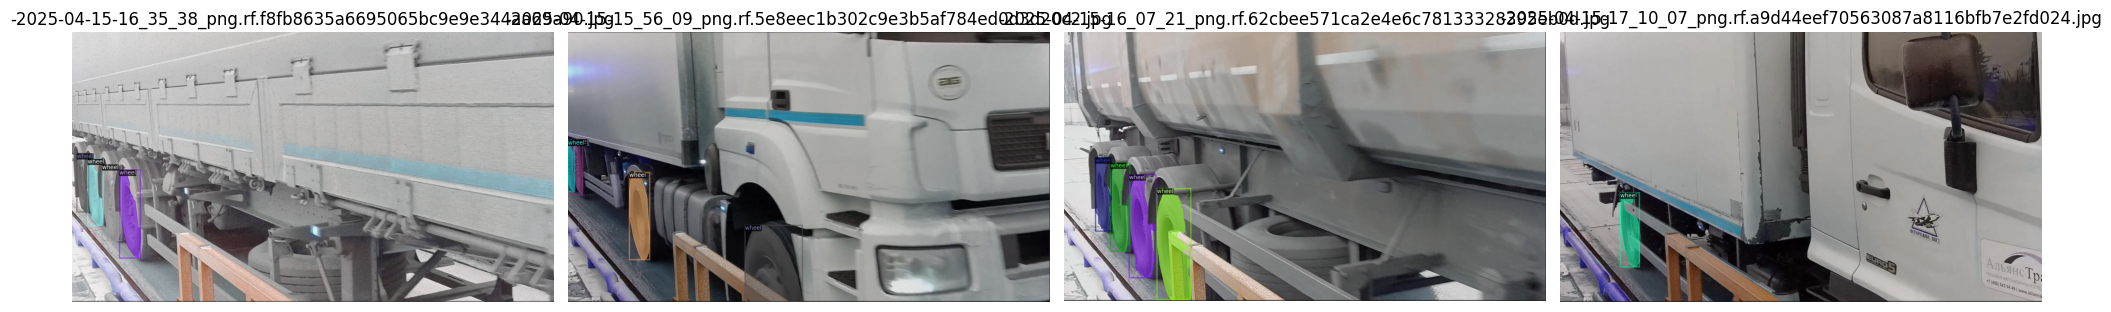

=== Preview of t_end: 853 images ===


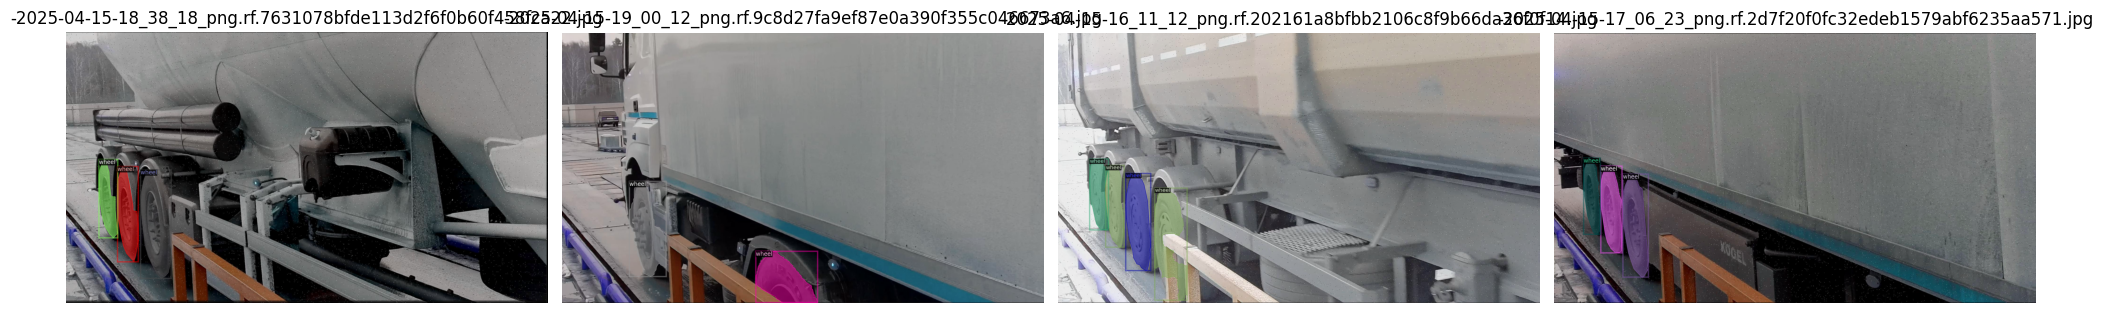

=== Preview of v_start: 112 images ===


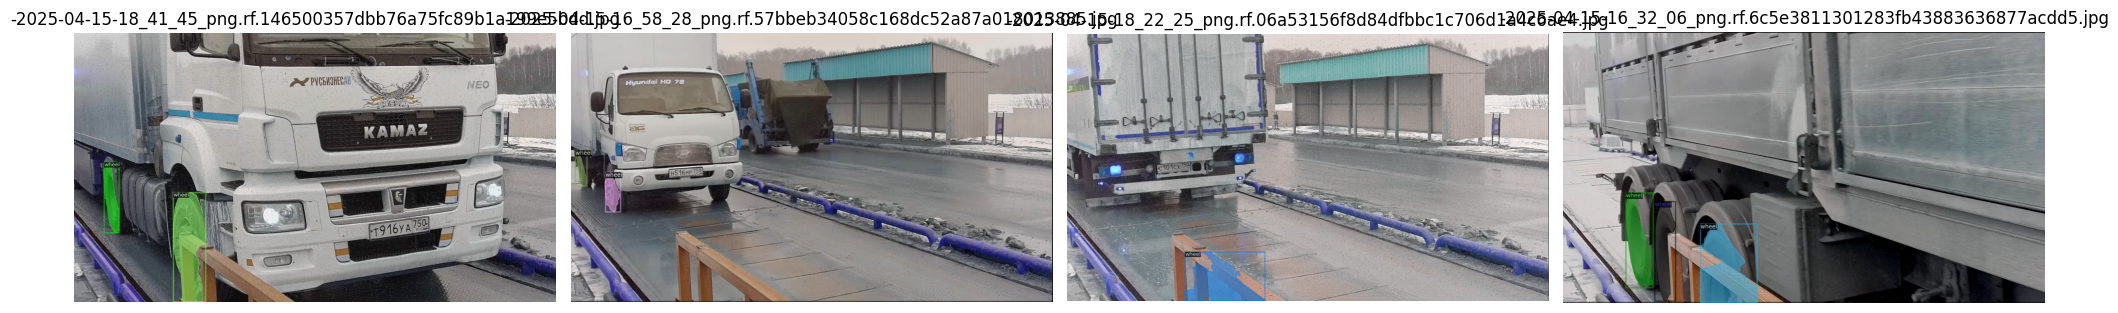

=== Preview of v_end: 112 images ===


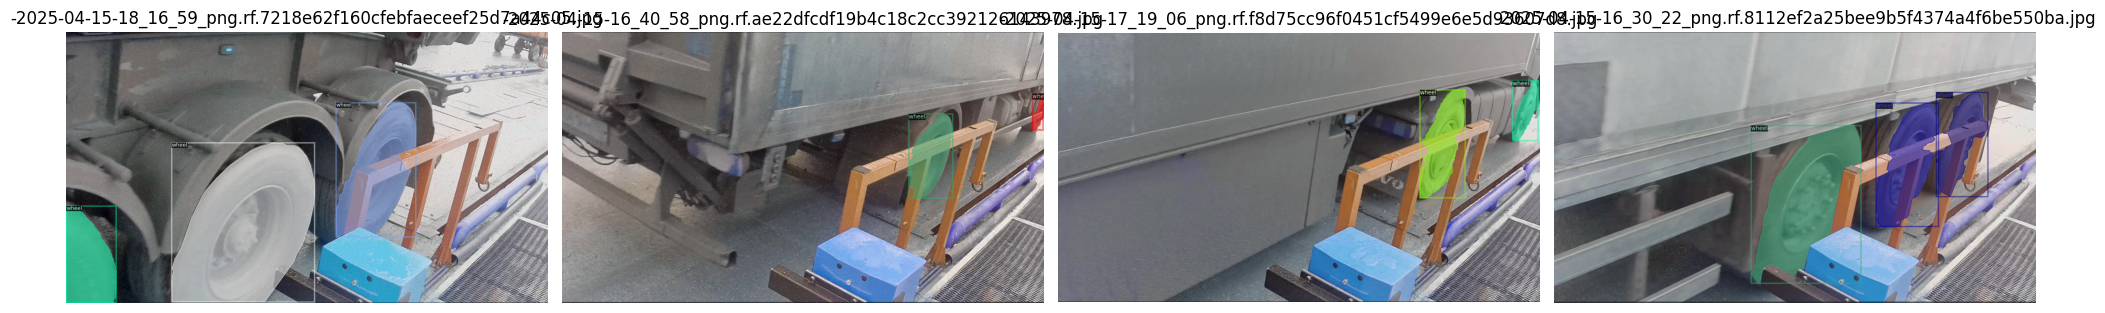

In [7]:
import os
import random
import cv2
import matplotlib.pyplot as plt

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer

# Список зарегистрированных датасетов
splits = ["t_start", "t_end", "v_start", "v_end"]

for ds_name in splits:
    # Получаем список записей и метаданные
    dataset_dicts = DatasetCatalog.get(ds_name)
    metadata     = MetadataCatalog.get(ds_name)
    
    print(f"=== Preview of {ds_name}: {len(dataset_dicts)} images ===")
    # Если в датасете меньше 4 изображений, покажем все
    sample_dicts = random.sample(dataset_dicts, min(4, len(dataset_dicts)))
    
    # Одинаково растянем по ширине
    fig, axes = plt.subplots(1, len(sample_dicts), figsize=(5*len(sample_dicts), 5))
    if len(sample_dicts) == 1:
        axes = [axes]
    
    for ax, d in zip(axes, sample_dicts):
        img_path = d["file_name"]  # у load_coco_json это уже полный путь
        img = cv2.imread(img_path)
        if img is None:
            ax.set_title("Image not found")
            ax.axis("off")
            continue
        
        # Визуализатор на основе Detectron2
        v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
        vis = v.draw_dataset_dict(d)
        out_img = vis.get_image()[:, :, ::-1]
        
        ax.imshow(out_img)
        ax.set_title(os.path.basename(img_path))
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

In [8]:
# -------------------------------------------------------------------
if not hasattr(np, 'bool'):
    np.bool = bool   # либо np.bool_ 
# 3. Тренировка двух моделей: start и end
# -------------------------------------------------------------------
setup_logger()  # инициализирует логирование Detectron2

# Конфиги
cfg_start = make_cfg(
    name="start", train_ds="t_start", val_ds="v_start",
    output_dir=os.path.join(OUTPUT_ROOT, "start"), max_iter=8000
)
cfg_end = make_cfg(
    name="end", train_ds="t_end", val_ds="v_end",
    output_dir=os.path.join(OUTPUT_ROOT, "end"), max_iter=8000
)

# Тренеры
trainer_start = DefaultTrainer(cfg_start)
trainer_start.resume_or_load(resume=False)
trainer_start.train()

trainer_end = DefaultTrainer(cfg_end)
trainer_end.resume_or_load(resume=False)
trainer_end.train()

# -------------------------------------------------------------------
# 4. Оценка и логирование метрик в CSV
# -------------------------------------------------------------------
def evaluate_and_log(cfg, ds_name, csv_path):
    evaluator = COCOEvaluator(ds_name, cfg, False, output_dir=cfg.OUTPUT_DIR)
    val_loader = build_detection_test_loader(cfg, ds_name)
    metrics    = inference_on_dataset(DefaultTrainer.build_model(cfg), val_loader, evaluator)
    # Возвращаем только маски (segm)
    segm = metrics.get("segm", {})
    row = {
        "dataset": ds_name,
        "AP50:95": segm.get("AP", 0),
        "AP50":    segm.get("AP50", 0),
        "AP75":    segm.get("AP75", 0),
        "APs":     segm.get("APs", 0),
        "APm":     segm.get("APm", 0),
        "APl":     segm.get("APl", 0)
    }
    # допишем в CSV
    df = pd.DataFrame([row])
    if not os.path.exists(csv_path):
        df.to_csv(csv_path, index=False)
    else:
        df.to_csv(csv_path, mode="a", header=False, index=False)
    return metrics

csv_path = os.path.join(OUTPUT_ROOT, "val_metrics.csv")
metrics_start = evaluate_and_log(cfg_start, "wheels_val", csv_path)
metrics_end   = evaluate_and_log(cfg_end,   "wheels_val", csv_path)

# -------------------------------------------------------------------
# 5. Инференс: загружаем лучшие веса и делаем predict по тегу
# -------------------------------------------------------------------
predictor_start = DefaultPredictor(cfg_start)
predictor_end   = DefaultPredictor(cfg_end)

def infer(image, tag):
    """
    image: NumPy HWC BGR
    tag: 'start' или 'end'
    """
    pred = (predictor_start if tag=="start" else predictor_end)(image)
    return pred["instances"]

# -------------------------------------------------------------------
# 6. Визуализация 4 случайных примеров из валидации
# -------------------------------------------------------------------
meta = MetadataCatalog.get("wheels_val")
dataset_dicts = DatasetCatalog.get("wheels_val")

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(os.path.join(IMG_DIR, d["file_name"]))
    # определяем tag по user_tags
    tag = "start" if "start" in d.get("extra",{}).get("user_tags",[]) else "end"
    inst = infer(img, tag)
    vis = Visualizer(img[:,:,::-1], metadata=meta, scale=0.8)
    out = vis.draw_instance_predictions(inst.to("cpu"))
    result_img = out.get_image()[:, :, ::-1]
    plt.figure(figsize=(8,6))
    plt.imshow(result_img)
    plt.title(f"tag={tag}, file={d['file_name']}")
    plt.axis("off")
    plt.show()

print("Готово! Метрики сохранены в", csv_path)

/tmp/ipykernel_35/2567540927.py:2: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'bool'):


[05/15 01:44:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

R-50.pkl: 102MB [00:00, 133MB/s]                             

[05/15 01:44:12 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......


[05/15 01:44:12 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint      | Shapes                                          |
|:------------------|:-------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*    | res2_1_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/15 01:44:27 d2.utils.events]:  eta: 1:15:59  iter: 19  total_loss: 6.012  loss_cls: 4.533  loss_box_reg: 0.02734  loss_mask: 0.6904  loss_rpn_cls: 0.6938  loss_rpn_loc: 0.06455  time: 0.5758  data_time: 0.0285  lr: 1.9981e-06  max_mem: 3027M
[05/15 01:44:39 d2.utils.events]:  eta: 1:16:10  iter: 39  total_loss: 5.612  loss_cls: 4.13  loss_box_reg: 0.04251  loss_mask: 0.6893  loss_rpn_cls: 0.692  loss_rpn_loc: 0.07169  time: 0.5786  data_time: 0.0097  lr: 3.9961e-06  max_mem: 3027M
[05/15 01:44:50 d2.utils.events]:  eta: 1:16:34  iter: 59  total_loss: 4.696  loss_cls: 3.187  loss_box_reg: 0.02402  loss_mask: 0.6866  loss_rpn_cls: 0.6867  loss_rpn_loc: 0.05621  time: 0.5820  data_time: 0.0092  lr: 5.9941e-06  max_mem: 3027M
[05/15 01:45:02 d2.utils.events]:  eta: 1:17:08  iter: 79  total_loss: 3.307  loss_cls: 1.85  loss_box_reg: 0.03874  loss_mask: 0.6832  loss_rpn_cls: 0.6792  loss_rpn_loc: 0.06309  time: 0.5862  data_time: 0.0100  lr: 7.9921e-06  max_mem: 3028M
[05/15 01:45:15 d2.

KeyboardInterrupt: 

In [45]:
!export CUDA_LAUNCH_BLOCKING=1

In [ ]:
# -*- coding: utf-8 -*-
import os, random
import cv2, json, pandas as pd
import matplotlib.pyplot as plt
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor, DefaultTrainer, hooks, HookBase, EvalHook
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data.datasets import load_coco_json
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.logger import setup_logger
from detectron2.checkpoint import PeriodicCheckpointer, DetectionCheckpointer
from detectron2.data.dataset_mapper import DatasetMapper
from detectron2.solver import build_optimizer, build_lr_scheduler
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T

# ============================================================================ #
# 0) Monkey‐patch для PIL и numpy, если нужно                                   
# ============================================================================ #
try:
    from PIL import Image
    if not hasattr(Image,'LINEAR'):
        from PIL.Image import Resampling
        Image.NEAREST=Resampling.NEAREST; Image.BILINEAR=Resampling.BILINEAR
        Image.LINEAR=Resampling.BILINEAR
except:
    pass
import numpy as np
if not hasattr(np,'bool'):
    np.bool = bool

# ============================================================================ #
# 1) Регистрируем COCO-сплиты (после remap target class→0!)                     
# ============================================================================ #
DATA_ROOT = '/kaggle/working/wheels3k-coco'
IMG_DIR   = os.path.join(DATA_ROOT, 'train/images')
DS_DIR    = os.path.join(DATA_ROOT, 'datasets_filtered')  # после remap & filter


# ============================================================================ #
# 2) Конфигурируем Mask R-CNN с DataAugmentation + Scheduler + Optimizer       
# ============================================================================ #
def make_cfg(train_ds, val_ds, output_dir, max_iter=8000, base_lr=1e-3):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN        = (train_ds,)
    cfg.DATASETS.TEST         = (val_ds,)
    cfg.DATALOADER.NUM_WORKERS = 4
    # DataAugmentations (цвет, яркость, контраст)
    cfg.INPUT.MIN_SIZE_TRAIN = 600
    cfg.INPUT.MAX_SIZE_TRAIN = 1024
    cfg.INPUT.MIN_SIZE_TEST  = 600
    cfg.INPUT.MAX_SIZE_TEST  = 1024

    cfg.SOLVER.IMS_PER_BATCH   = 4
    cfg.SOLVER.BASE_LR         = base_lr
    cfg.SOLVER.WEIGHT_DECAY     = 1e-4
    cfg.SOLVER.WARMUP_ITERS     = 500
    cfg.SOLVER.WARMUP_METHOD    = "linear"
    cfg.SOLVER.MAX_ITER        = max_iter
    cfg.SOLVER.STEPS           = (int(max_iter*0.6), int(max_iter*0.9))
    cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"

    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
    cfg.MODEL.ROI_HEADS.NUM_CLASSES         = 1
    cfg.OUTPUT_DIR = output_dir
    os.makedirs(output_dir, exist_ok=True)
    return cfg

# ============================================================================ #
# 3) Собираем свой Trainer с BestCheckpointer и EarlyStopping                   
# ============================================================================ #
class BestCheckpointer(HookBase):
    def __init__(self, checkpointer, eval_period, get_metric, save_path):
        self.checkpointer = checkpointer
        self.eval_period  = eval_period
        self.get_metric   = get_metric
        self.best_metric  = -float("inf")
        self.save_path    = save_path

    def after_step(self):
        it = self.trainer.iter
        # Ждём конца эпохи (или eval_period) и хотя бы первой валидации
        if it == 0 or (it + 1) % self.eval_period != 0:
            return
        # Попытаемся получить метрику из storage, если есть
        history = self.trainer.storage._history.get("segm/AP50", None)
        if not history:
            return
        metric = history[-1]
        if metric > self.best_metric:
            self.best_metric = metric
            self.checkpointer.save(self.save_path)

class EarlyStoppingHook(HookBase):
    def __init__(self, patience, eval_period, get_metric):
        self.patience    = patience
        self.eval_period = eval_period
        self.get_metric  = get_metric
        self.best        = -float("inf")
        self.wait        = 0

    def after_step(self):
        it = self.trainer.iter
        # Пропускаем пока не дошли до первой валидации
        if it == 0 or (it + 1) % self.eval_period != 0:
            return
        history = self.trainer.storage._history.get("segm/AP50", None)
        if not history:
            return
        metric = history[-1]
        if metric > self.best:
            self.best = metric
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"[EarlyStopping] no improvement in {self.patience} evals -> stop")
                # Прекращаем тренинг
                self.trainer.storage.put_scalar("early_stop", 1)
                raise StopIteration

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        # Собираем список аугментаций
        aug_list = [
            T.RandomBrightness(0.9, 1.1),
            T.RandomContrast(0.8, 1.2),
        ]
        mapper = DatasetMapper(cfg, is_train=True, augmentations=aug_list)
        return build_detection_train_loader(cfg, mapper=mapper)


    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        os.makedirs(output_folder or cfg.OUTPUT_DIR, exist_ok=True)
        return COCOEvaluator(dataset_name, cfg, False, output_folder or cfg.OUTPUT_DIR)

    from detectron2.engine import HookBase

    @classmethod
    def build_optimizer(cls, cfg, model):
        backbone_params = [p for _, p in model.backbone.named_parameters() if p.requires_grad]
        roi_head_params = [p for _, p in model.roi_heads.named_parameters() if p.requires_grad]
        params = [
            {"params": backbone_params, "lr": cfg.SOLVER.BASE_LR * 0.1},
            {"params": roi_head_params, "lr": cfg.SOLVER.BASE_LR},
        ]
        return torch.optim.SGD(params, lr=cfg.SOLVER.BASE_LR,
                               momentum=0.9, weight_decay=cfg.SOLVER.WEIGHT_DECAY)

    def build_hooks(self):
        hooks_list = super().build_hooks()
        # Позиционируем после EvalHook
        eval_period = self.cfg.TEST.EVAL_PERIOD
        # Checkpointer для лучших
        checkpointer = DetectionCheckpointer(self.model, self.cfg.OUTPUT_DIR)
        best_cp = BestCheckpointer(
            checkpointer, 
            eval_period=eval_period,
            get_metric=lambda: None,  # метрику читаем внутри hook
            save_path="model_best"
        )
        early = EarlyStoppingHook(
            patience=5,
            eval_period=eval_period,
            get_metric=lambda: None
        )
        # Вставляем сразу после EvalHook
        for i, h in enumerate(hooks_list):
            if isinstance(h, EvalHook):
                hooks_list.insert(i+1, best_cp)
                hooks_list.insert(i+2, early)
                break
        return hooks_list

# ============================================================================ #
# 4) Тренировка start и end                                                    
# ============================================================================ #
setup_logger()

# Обязательно сохранить EVAL_PERIOD >0
cfg_s = make_cfg("t_start","v_start", OUT_DIR:=os.path.join(DATA_ROOT,"out_start"), max_iter=10000)
cfg_s.TEST.EVAL_PERIOD = 500
trainer_s = MyTrainer(cfg_s)
trainer_s.resume_or_load(resume=False)
trainer_s.train()

cfg_e = make_cfg("t_end","v_end", OUT_DIR2:=os.path.join(DATA_ROOT,"out_end"), max_iter=10000)
cfg_e.TEST.EVAL_PERIOD = 500
trainer_e = MyTrainer(cfg_e)
trainer_e.resume_or_load(resume=False)
trainer_e.train()

# ============================================================================ #
# 5) Оценка + CSV лог + TensorBoard                                           
# ============================================================================ #
def evaluate_and_log(cfg, split, tag):
    evaluator = COCOEvaluator(split, cfg, False, output_dir=cfg.OUTPUT_DIR)
    val_loader = build_detection_test_loader(cfg, split)
    metrics    = inference_on_dataset(trainer_s.model if tag=="start" else trainer_e.model, val_loader, evaluator)
    segm = metrics.get("segm", {})
    row = {"tag":tag, "AP50:95":segm.get("AP",0), "AP50":segm.get("AP50",0)}
    df = pd.DataFrame([row])
    f = os.path.join(DATA_ROOT, "metrics.csv")
    df.to_csv(f, mode='a', header=not os.path.exists(f), index=False)
    # TensorBoard
    for k,v in row.items():
        if k!="tag": tb_writer.add_scalar(f"val/{tag}/{k}", v)
    return metrics

m_s = evaluate_and_log(cfg_s, "v_start","start")
m_e = evaluate_and_log(cfg_e, "v_end",  "end")



[05/15 02:13:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res